In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install datasets
!pip install torch
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 17.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [5]:
import numpy as np
import pandas as pd
import datasets
import cv2
import os
import pickle
from PIL import Image,ImageDraw,ImageFont
from transformers import AutoProcessor
from datasets import  Dataset,ClassLabel,Features,Value,Sequence,Array3D,Dataset,Features,load_dataset,DatasetDict, Array2D  #Image
from torchvision.transforms import functional as F

In [6]:
ah='/content/drive/MyDrive/Dajjal/temp/tsv/tsv'
davy='/content/drive/MyDrive/Dajjal/temp/png'
dol=[o for o in range(len(os.listdir(ah)))]
b_box=[]
l_label=[]
t_text=[]
l_link=[]
m_image=[]
for k,j,img in zip(dol,os.listdir(ah),os.listdir(davy)):
  path=os.path.join(ah,j)
  df=pd.read_table(path)
  col=df.columns[0]
  box=[]
  label=[]
  text=[]
  link=[]
  unique=[]
  for i in df[col]:
    i=i.split(',')
    box.append([int(i[2]),int(i[3]),int(i[4]),int(i[5])])
    text.append(i[6])
    link.append([int(i[0]),int(i[1])])
    if i[-1]=='taxYear':
      label.append(0)
    elif i[-1]=='OTHER':
      label.append(1)
    elif i[-1]=='box17StateIncomeTax':
      label.append(2)
    elif i[-1]=='box16StateWagesTips':
      label.append(3)
    elif i[-1]=='employeeName':
      label.append(4)
    elif i[-1]=='ssnOfEmployee':
      label.append(5)
    elif i[-1]=='einEmployerIdentificationNumber':
      label.append(6)
    elif i[-1]=='employerAddressZip':
      label.append(7)
    elif i[-1]== 'employerAddressState':
      label.append(8)
    elif i[-1]=='employerAddressCity':
      label.append(9)
    elif i[-1]=='employerAddressStreet_name':
      label.append(10)
    elif i[-1]=='employerName':
      label.append(11)
    elif i[-1]=='box4SocialSecurityTaxWithheld':
      label.append(12)
    elif i[-1]=='box3SocialSecurityWages':
      label.append(13)
    elif i[-1]=='box2FederalIncomeTaxWithheld':
      label.append(14)
    elif i[-1]=='box1WagesTipsAndOtherCompensations':
      label.append(15)
  png_image = Image.open(os.path.join(davy,img))
  b_box.append(box)
  l_label.append(label)
  t_text.append(text)
  l_link.append(link)
  m_image.append(png_image)
  if k==4:
    break

print(len(b_box))
print(len(l_label))
print(len(t_text))
print(len(l_link))
print(len(m_image))

5
5
5
5
5


In [7]:
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),]

In [8]:
ah='/content/drive/MyDrive/Dajjal/temp/tsv/tsv'
davy='/content/drive/MyDrive/Dajjal/temp/png'
dol=[o for o in range(len(os.listdir(ah)))]
_box=[]
_label=[]
_text=[]
_link=[]
_image=[]
_uniq=[]
temp=[]
for k,j,img in zip(dol,os.listdir(ah),os.listdir(davy)):
  path=os.path.join(ah,j)
  df=pd.read_table(path)
  col=df.columns[0]
  temp_base=[]
  box=[]
  label=[]
  text=[]
  link=[]
  unique=[]
  png_image = Image.open(os.path.join(davy,img))
  height,width=png_image.size
  for i in df[col]:
    i=i.split(',')
    cn=[int(i[2]),int(i[3]),int(i[4]),int(i[5])]
    #box.append(normalize_bbox(cn, width, height))
    dn=normalize_bbox(cn, width, height)
    if dn[0]>=1000:
      unique.append([dn[0],i[6],i[-1]])
    elif dn[1]>=1000:
      unique.append([dn[1],i[6],i[-1]])
    elif dn[2]>=1000:
      unique.append([dn[2],i[6],i[-1]])
    elif dn[3]>=1000:
      unique.append([dn[3],i[6],i[-1]])
    if dn[0]<=1000 and dn[1]<=1000 and dn[2]<=1000 and dn[3]<=1000:
      box.append(dn)
      text.append(i[6])
      label.append(i[-1])
      temp_base.append(cn)
#___________________________________________
#    b1=int(1000 * int(i[2]) / width)
#    b2=int(1000 * int(i[3]) / height)
#    b3=int(1000 * int(i[4]) / width)
#    b4=int(1000 * int(i[5]) / height)
#    box.append([b1,b2,b3,b4])______________

 #   i[2] |i[3] |i[4] |i[5]
 #   x_min|y_min|x_max|y_max

#    width=int(i[4])-int(i[2])
#    height=int(i[5])-int(i[3])
#    width_scale = 1000 / width
#    height_scale = 1000 / height

#    x_min = (int(i[2]) - int(i[2])) * width_scale
#    y_min = (int(i[3]) - int(i[3])) * height_scale
#    x_max = (int(i[4]) - int(i[2])) * width_scale
#    y_max = (int(i[5]) - int(i[3])) * height_scale
#    x_min,y_min,x_max,y_max=round(x_min),round(y_min),round(x_max),round(y_max)

#    box.append([x_min,y_min,x_max,y_max])
#__________________________________________________

#    text.append(i[6])
#    link.append([int(i[0]),int(i[1])])
#    label.append(i[-1])

  _box.append(box)
  _label.append(label)
  _text.append(text)
  _link.append(link)
  _image.append(png_image)
  _uniq.append(unique)
  temp.append(temp_base)
  if k==2:
    break

print(len(b_box))
print(len(l_label))
print(len(t_text))
print(len(l_link))
print(len(m_image))

5
5
5
5
5


height:2550
width:3300


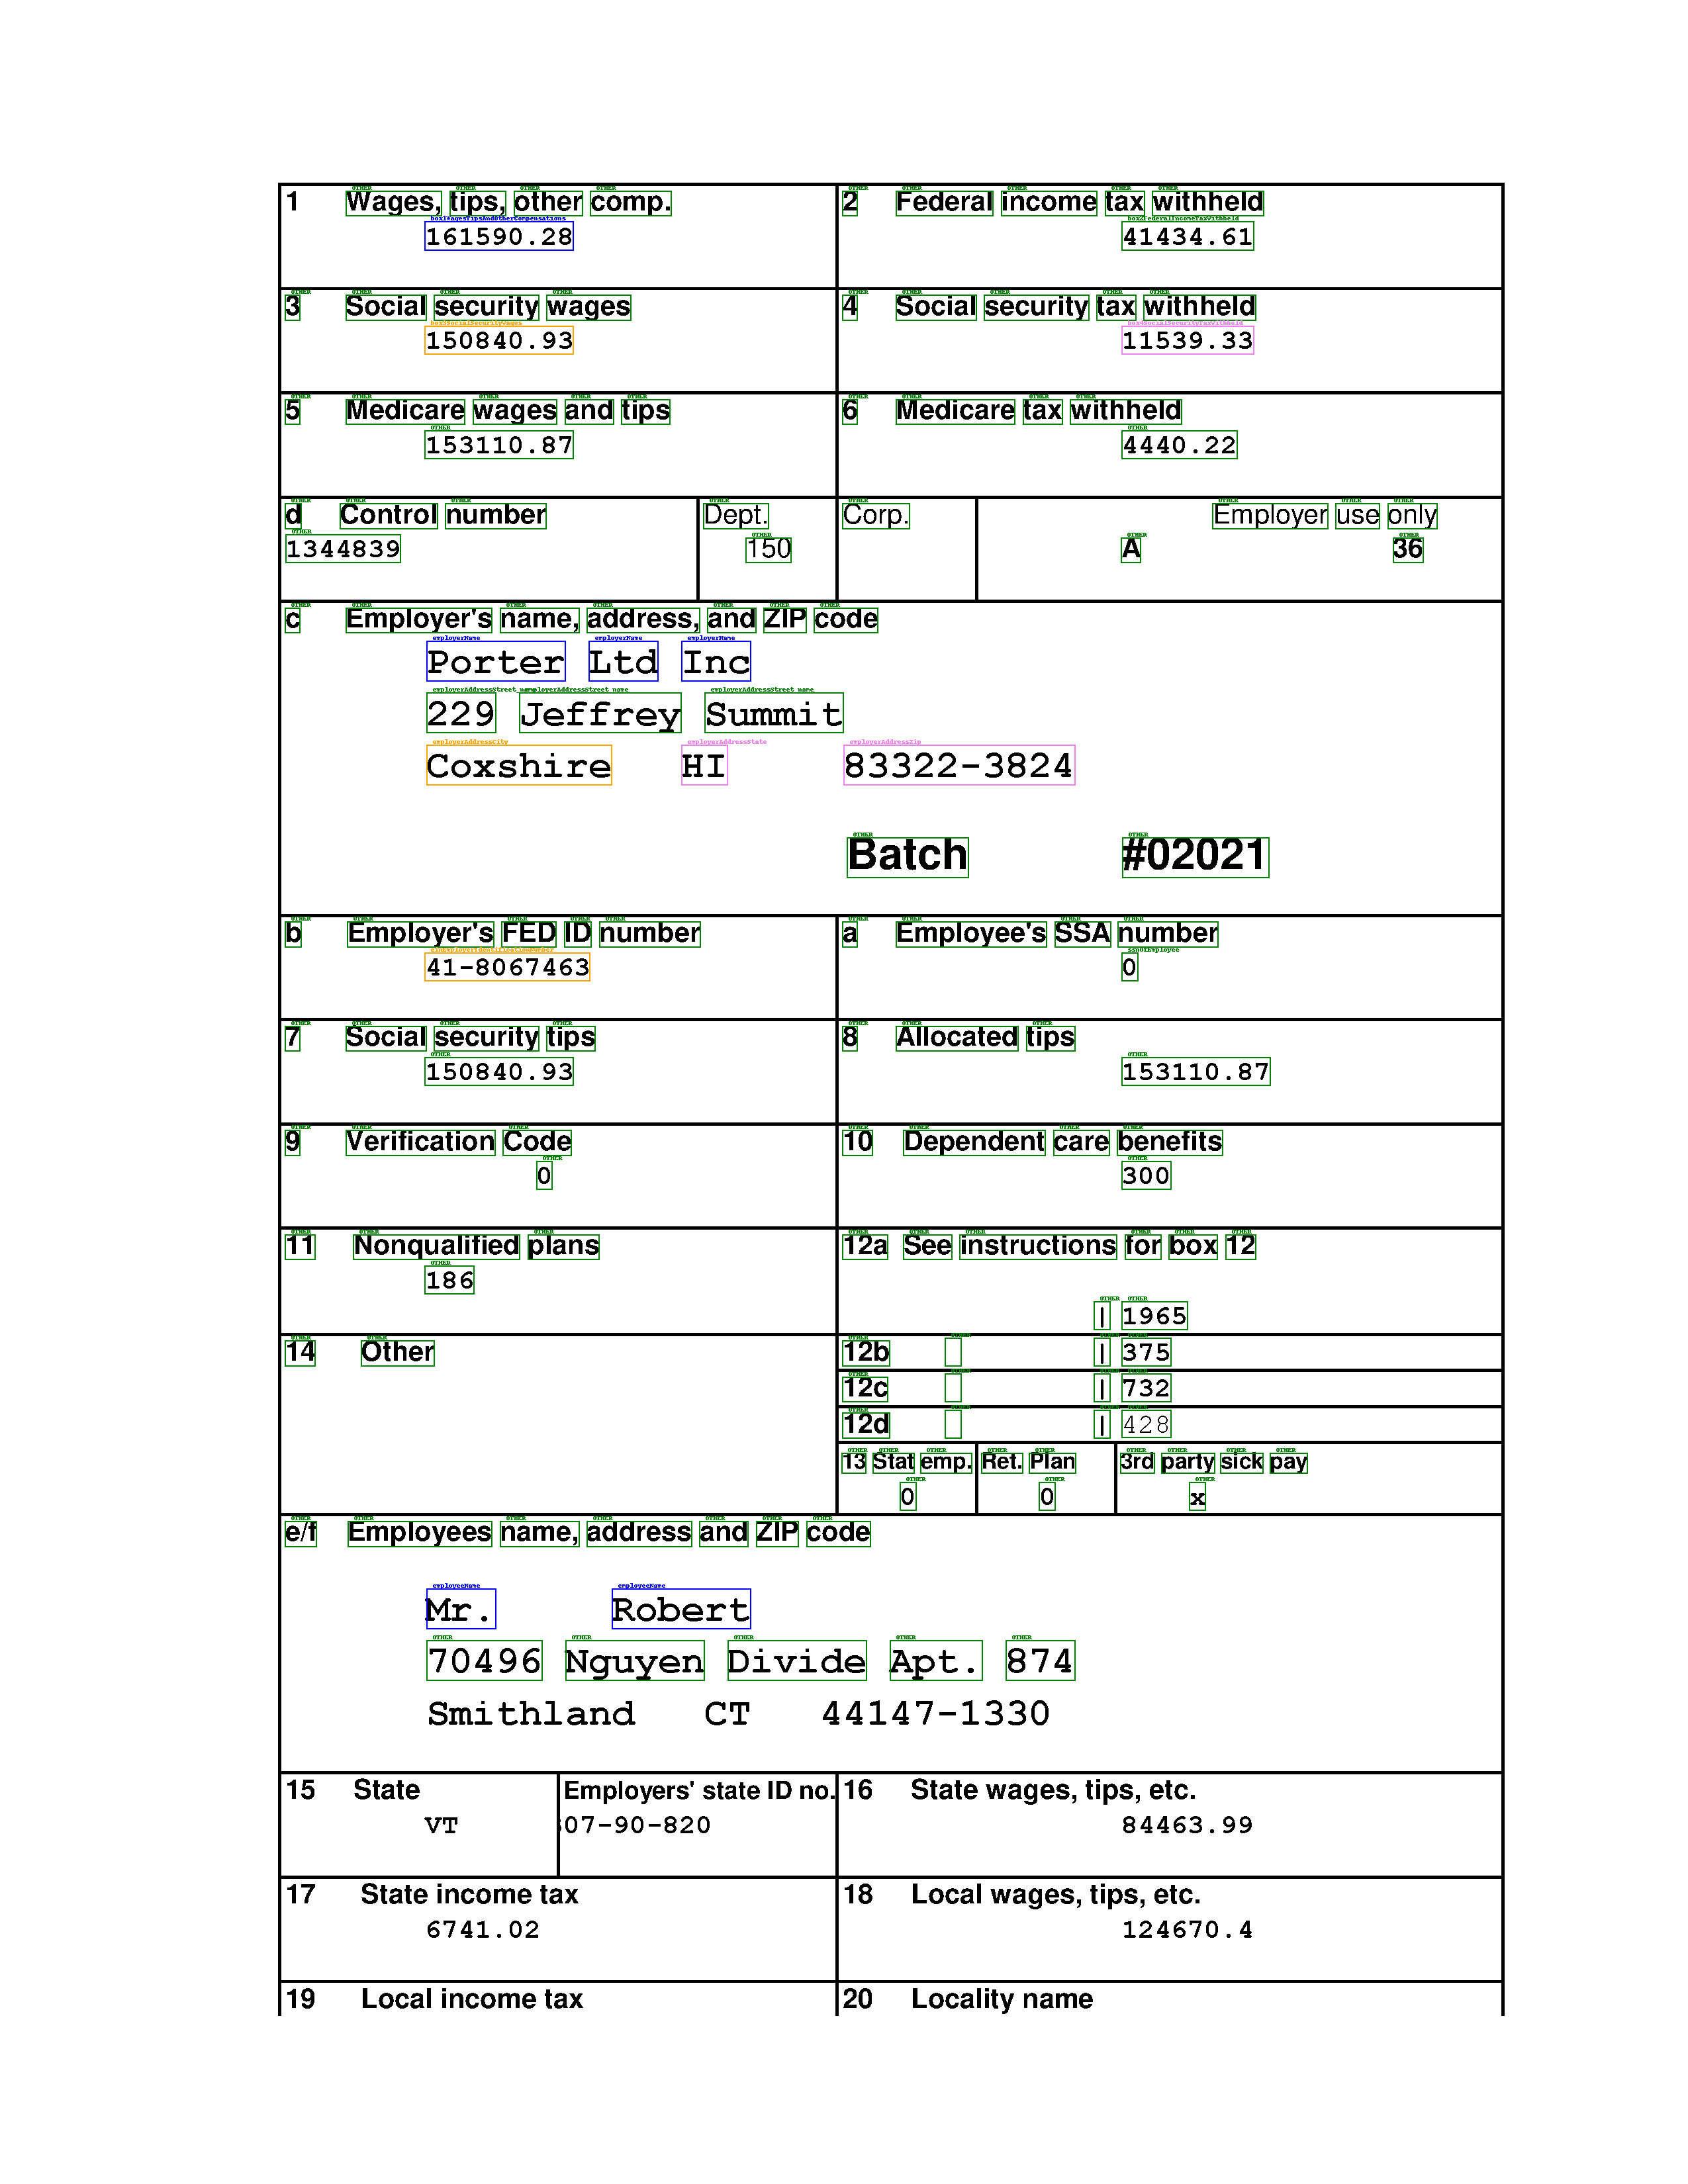

In [9]:
image = image=Image.open('/content/drive/MyDrive/Dajjal/temp/png/0b55f878-9dc7-478b-9bba-342056684452_document-5_page-1.png')

label2color = {'box1WagesTipsAndOtherCompensations':'blue', 'box2FederalIncomeTaxWithheld':'green', 'box3SocialSecurityWages':'orange', 'box4SocialSecurityTaxWithheld':'violet','employerName': 'blue', 'employerAddressStreet_name': 'green', 'employerAddressCity': 'orange', 'employerAddressState': 'violet','employerAddressZip': 'violet', 'einEmployerIdentificationNumber': 'orange', 'ssnOfEmployee': 'green','employeeName': 'blue', 'box16StateWagesTips': 'blue', 'box17StateIncomeTax': 'green', 'OTHER': 'green', 'taxYear': 'green'}

image = image.convert("RGB")
height,width=image.size
draw = ImageDraw.Draw(image, "RGBA")
font = ImageFont.load_default()

for i,j in zip(temp[0],_label[0]):
    label=j
    general_box=i
    draw.rectangle(general_box, outline=label2color[label], width=2)
    draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
 #   draw.rectangle(box, outline=label2color[label], width=1)
    #draw.text((box[0] + 10, box[1] - 10),text=label, font=font)
print(f'height:{height}')
print(f'width:{width}')
image

In [10]:
labels=['box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld', 'box3SocialSecurityWages','box4SocialSecurityTaxWithheld', 'employerName', 'employerAddressStreet_name',
 'employerAddressCity','employerAddressState', 'employerAddressZip', 'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName', 'box16StateWagesTips',
 'box17StateIncomeTax', 'OTHER', 'taxYear']

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

print(labels)
print()
print(id2label)
print()
print(label2id)

['box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld', 'box3SocialSecurityWages', 'box4SocialSecurityTaxWithheld', 'employerName', 'employerAddressStreet_name', 'employerAddressCity', 'employerAddressState', 'employerAddressZip', 'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName', 'box16StateWagesTips', 'box17StateIncomeTax', 'OTHER', 'taxYear']

{0: 'box1WagesTipsAndOtherCompensations', 1: 'box2FederalIncomeTaxWithheld', 2: 'box3SocialSecurityWages', 3: 'box4SocialSecurityTaxWithheld', 4: 'employerName', 5: 'employerAddressStreet_name', 6: 'employerAddressCity', 7: 'employerAddressState', 8: 'employerAddressZip', 9: 'einEmployerIdentificationNumber', 10: 'ssnOfEmployee', 11: 'employeeName', 12: 'box16StateWagesTips', 13: 'box17StateIncomeTax', 14: 'OTHER', 15: 'taxYear'}

{'box1WagesTipsAndOtherCompensations': 0, 'box2FederalIncomeTaxWithheld': 1, 'box3SocialSecurityWages': 2, 'box4SocialSecurityTaxWithheld': 3, 'employerName': 4, 'employerAddressStreet

In [11]:
label2color = {'box1WagesTipsAndOtherCompensations':'blue', 'box2FederalIncomeTaxWithheld':'green', 'box3SocialSecurityWages':'orange', 'box4SocialSecurityTaxWithheld':'violet','employerName': 'blue', 'employerAddressStreet_name': 'green', 'employerAddressCity': 'orange', 'employerAddressState': 'violet','employerAddressZip': 'violet', 'einEmployerIdentificationNumber': 'orange', 'ssnOfEmployee': 'green','employeeName': 'blue', 'box16StateWagesTips': 'blue', 'box17StateIncomeTax': 'green', 'OTHER': 'green', 'taxYear': 'green'}
label2color

{'box1WagesTipsAndOtherCompensations': 'blue',
 'box2FederalIncomeTaxWithheld': 'green',
 'box3SocialSecurityWages': 'orange',
 'box4SocialSecurityTaxWithheld': 'violet',
 'employerName': 'blue',
 'employerAddressStreet_name': 'green',
 'employerAddressCity': 'orange',
 'employerAddressState': 'violet',
 'employerAddressZip': 'violet',
 'einEmployerIdentificationNumber': 'orange',
 'ssnOfEmployee': 'green',
 'employeeName': 'blue',
 'box16StateWagesTips': 'blue',
 'box17StateIncomeTax': 'green',
 'OTHER': 'green',
 'taxYear': 'green'}

len of box:1>len of label:1>len of text:1>len of Image:1
height>>1236,width>>1657


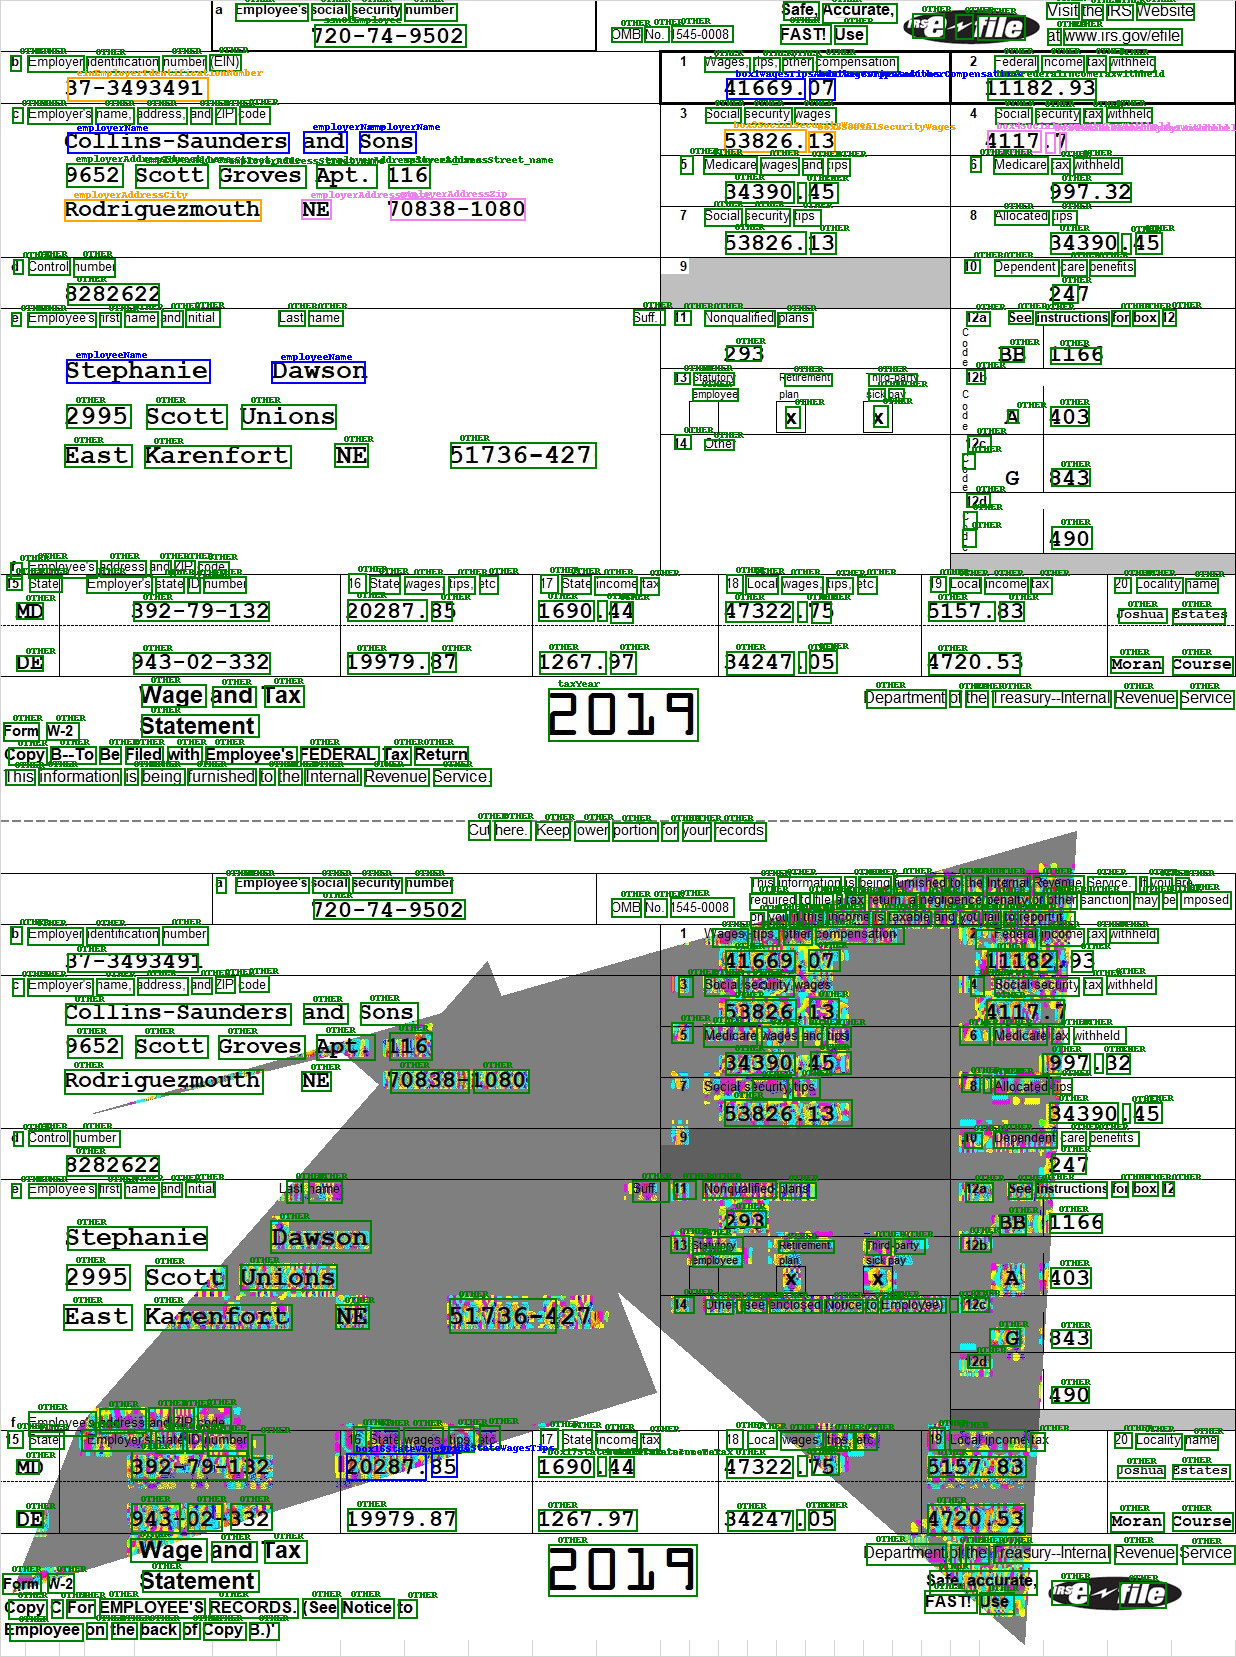

In [12]:
cal='/content/drive/MyDrive/Dajjal/infrrd_data/train/tsv'
davy_jones='/content/drive/MyDrive/Dajjal/infrrd_data/train/image'
dol=[o for o in range(len(os.listdir(cal)))]

inf_box=[]
inf_label=[]
inf_text=[]
inf_image=[]

for k,j,img in zip(dol,os.listdir(cal),os.listdir(davy_jones)):
  path=os.path.join(cal,j)
  df=pd.read_table(path)
  col=df.columns[0]

  box=[]
  label=[]
  text=[]
  png_image = Image.open(os.path.join(davy_jones,img))
  height,width=png_image.size
  for i in df[col]:
    i=i.split(',')
    cn=[int(i[2]),int(i[3]),int(i[4]),int(i[5])]
    box.append(cn)
    text.append(i[6])
    label.append(i[-1])

  inf_box.append(box)
  inf_label.append(label)
  inf_text.append(text)
  inf_image.append(png_image)
  break   # only one iteration is enough for inference test without normalize box function

print(f'len of box:{len(inf_box)}>len of label:{len(inf_label)}>len of text:{len(inf_text)}>len of Image:{len(inf_image)}')
#_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
from PIL import ImageDraw
from PIL import Image, ImageDraw, ImageFont

label2color = {'box1WagesTipsAndOtherCompensations':'blue', 'box2FederalIncomeTaxWithheld':'green', 'box3SocialSecurityWages':'orange', 'box4SocialSecurityTaxWithheld':'violet','employerName': 'blue', 'employerAddressStreet_name': 'green', 'employerAddressCity': 'orange', 'employerAddressState': 'violet','employerAddressZip': 'violet', 'einEmployerIdentificationNumber': 'orange', 'ssnOfEmployee': 'green','employeeName': 'blue', 'box16StateWagesTips': 'blue', 'box17StateIncomeTax': 'green', 'OTHER': 'green', 'taxYear': 'green'}

label=['box1WagesTipsAndOtherCompensations','box2FederalIncomeTaxWithheld', 'box3SocialSecurityWages', 'box4SocialSecurityTaxWithheld', 'employerName', 'employerAddressStreet_name','employerAddressCity', 'employerAddressState','employerAddressZip', 'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName', 'box16StateWagesTips','box17StateIncomeTax','OTHER', 'taxYear']
image = image=Image.open('/content/drive/MyDrive/Dajjal/infrrd_data/train/image/004a4c67-561d-4d9c-9ef2-47cb15fbdf08_document-2_page-1.jpg')
image = image.convert("RGB")
height,width=image.size
draw = ImageDraw.Draw(image, "RGBA")
font = ImageFont.load_default()

for i,j in zip(inf_box[0],inf_label[0]):
    label=j
    general_box=i
    draw.rectangle(general_box, outline=label2color[label], width=2)
    draw.text((general_box[0] + 10, general_box[1] - 10), label, fill=label2color[label], font=font)
 #   draw.rectangle(box, outline=label2color[label], width=1)
    #draw.text((box[0] + 10, box[1] - 10),text=label, font=font)
print(f'height>>{height},width>>{width}')
image

Training Data >>>

---



In [13]:
def normalize_bbox(bbox, width, height):
    return [
        int(1000 * (bbox[0] / width)),
        int(1000 * (bbox[1] / height)),
        int(1000 * (bbox[2] / width)),
        int(1000 * (bbox[3] / height)),]

In [14]:
# training data preparation with normalize function
from PIL import Image
cal='/content/drive/MyDrive/Dajjal/infrrd_data/train/tsv'
davy_jones='/content/drive/MyDrive/Dajjal/infrrd_data/train/image'
dol=[o for o in range(len(os.listdir(cal)))]
train_box=[]
train_label=[]
train_text=[]
train_image=[]
train_uniq=[]

for k,j,img in zip(dol,os.listdir(cal),os.listdir(davy_jones)):
  path=os.path.join(cal,j)
  df=pd.read_table(path)
  col=df.columns[0]
  box=[]
  label=[]
  text=[]
  unique=[]
  png_image = Image.open(os.path.join(davy_jones,img))
  height,width=png_image.size
# print(height,width)
  for i in df[col]:
    i=i.split(',')
    cn=[int(i[2]),int(i[3]),int(i[4]),int(i[5])]
    dn=normalize_bbox(cn, width, height)
    if dn[0]>=1000:
      unique.append([dn[0],i[6],i[-1]])
    elif dn[1]>=1000:
      unique.append([dn[1],i[6],i[-1]])
    elif dn[2]>=1000:
      unique.append([dn[2],i[6],i[-1]])
    elif dn[3]>=1000:
      unique.append([dn[3],i[6],i[-1]])
    if dn[0]<=1000 and dn[1]<=1000 and dn[2]<=1000 and dn[3]<=1000:
      box.append(dn)
      text.append(i[6])
      label.append(i[-1])

  train_box.append(box)
  train_label.append(label)
  train_text.append(text)
  train_image.append(png_image)
  train_uniq.append(unique)

print(len(train_box))
print(len(train_label))
print(len(train_text))
print(len(train_image))

60
60
60
60


In [15]:
print(len(train_uniq[0]))  #  boxes with values<1000 wich in not feedable for training
print(len(train_box[0]))   #  boxes in range of 0-1000
print()
train_box[2][0:20]         # <<< normalize box range between 0-1000

121
398



[[498, 717, 547, 735],
 [591, 802, 622, 818],
 [217, 18, 223, 30],
 [227, 19, 269, 37],
 [270, 25, 292, 39],
 [293, 28, 321, 44],
 [323, 32, 352, 48],
 [99, 39, 105, 51],
 [108, 40, 141, 57],
 [141, 44, 182, 62],
 [184, 50, 209, 65],
 [210, 54, 227, 67],
 [270, 42, 355, 67],
 [129, 59, 207, 84],
 [437, 64, 454, 78],
 [455, 65, 469, 79],
 [470, 67, 503, 84],
 [534, 58, 555, 74],
 [555, 62, 602, 82],
 [97, 74, 104, 89]]

In [16]:
"""from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/Dajjal/infrrd_data2.zip','r') as fk:
  fk.extractall('/content/drive/MyDrive/Dajjal/')"""

"from zipfile import ZipFile\nwith ZipFile('/content/drive/MyDrive/Dajjal/infrrd_data2.zip','r') as fk:\n  fk.extractall('/content/drive/MyDrive/Dajjal/')"

In [17]:
# evaluation data preparation with normalize function
from PIL import Image
cal2='/content/drive/MyDrive/Dajjal/infrrd_data2/eval/tsv'
davy_jones2='/content/drive/MyDrive/Dajjal/infrrd_data2/eval/image'
dol=[o for o in range(len(os.listdir(cal2)))]
eval_box=[]
eval_label=[]
eval_text=[]
eval_image=[]

for k,j,img in zip(dol,os.listdir(cal2),os.listdir(davy_jones2)):
  path=os.path.join(cal2,j)
  df=pd.read_table(path)
  col=df.columns[0]
  e_box=[]
  e_label=[]
  e_text=[]
  e_png_image = Image.open(os.path.join(davy_jones2,img))
  height,width=e_png_image.size

  for i in df[col]:
    i=i.split(',')
    cn=[int(i[2]),int(i[3]),int(i[4]),int(i[5])]
    dn=normalize_bbox(cn, width, height)
    if dn[0]<=1000 and dn[1]<=1000 and dn[2]<=1000 and dn[3]<=1000:
      e_box.append(dn)
      e_text.append(i[6])
      e_label.append(i[-1])

  eval_box.append(e_box)
  eval_label.append(e_label)
  eval_text.append(e_text)
  eval_image.append(e_png_image)

print(len(eval_box))
print(len(eval_label))
print(len(eval_text))
print(len(eval_image))

20
20
20
20


In [18]:
# Create the DatasetDict
train_dict ={
        'tokens':train_text,
        'bboxes':train_box,
        'ner_tags':train_label,
        'image':train_image}
eval_dict ={
        'tokens':eval_text,
        'bboxes':eval_box,
        'ner_tags':eval_label,
        'image':eval_image  }
#print(train_dict.keys())
#print(train_dict['tokens'])
example=train_dict
_example=eval_dict
words, boxes, ner_tags,image =  example["tokens"][0], example["bboxes"][0], example["ner_tags"][0],example["image"][0]
print(boxes)
print(ner_tags)
print(words)
print(image)
print()
_words, _boxes, _ner_tags,_image =  _example["tokens"][0], _example["bboxes"][0], _example["ner_tags"][0],_example["image"][0]
print(_boxes)
print(_ner_tags)
print(_words)
print(_image)

[[141, 2, 185, 16], [187, 2, 210, 16], [212, 2, 242, 16], [243, 2, 275, 16], [472, 0, 494, 16], [496, 2, 541, 18], [631, 1, 651, 15], [652, 3, 665, 16], [667, 3, 683, 16], [685, 2, 720, 16], [189, 19, 281, 38], [368, 21, 387, 33], [388, 21, 403, 33], [404, 20, 442, 33], [470, 19, 501, 35], [503, 20, 523, 35], [550, 10, 569, 30], [576, 11, 587, 31], [589, 12, 618, 32], [631, 22, 640, 36], [641, 22, 713, 36], [6, 44, 12, 57], [16, 44, 50, 58], [51, 45, 95, 58], [97, 44, 124, 58], [126, 43, 145, 57], [424, 46, 452, 58], [454, 46, 470, 58], [471, 46, 490, 58], [492, 45, 541, 58], [599, 44, 626, 58], [628, 44, 654, 58], [655, 44, 667, 58], [669, 45, 697, 58], [40, 62, 125, 81], [438, 63, 485, 80], [488, 63, 503, 80], [595, 63, 661, 80], [7, 86, 13, 99], [16, 86, 55, 100], [57, 86, 80, 100], [82, 86, 112, 100], [114, 86, 127, 100], [129, 86, 142, 100], [144, 85, 162, 100], [425, 86, 447, 99], [449, 86, 477, 100], [479, 86, 504, 100], [600, 86, 622, 100], [624, 87, 651, 100], [653, 87, 665, 9

In [19]:
from transformers import AutoProcessor
from datasets import  Image,Dataset,ClassLabel,Features,Value,Sequence,Array3D,Dataset,Features,load_dataset,DatasetDict, Array2D ,Image
from torchvision.transforms import functional as F

_name=['box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld', 'box3SocialSecurityWages',
        'box4SocialSecurityTaxWithheld', 'employerName', 'employerAddressStreet_name', 'employerAddressCity',
        'employerAddressState', 'employerAddressZip', 'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName',
        'box16StateWagesTips', 'box17StateIncomeTax', 'OTHER', 'taxYear']

Features = Features({
    'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
     'ner_tags': Sequence(feature=ClassLabel(names=_name, id=None), length=-1, id=None),
   # 'image': Sequence(feature=Value(dtype='int64',id=None),length=-1,id=None)
     'image': Image(decode=True, id=None)
})

dataset_dict=Dataset.from_dict(train_dict,features=Features)


In [20]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
      return  {'id' : self.data['id'][index],
        'words' : self.data['words'][index],
        'bboxes' : self.data['bboxes'][index],
        'ner_tags' : self.data['ner_tags'][index],
        'image' : self.data['image'][index]  # Assuming the image data is in the required format (e.g., PIL image)
       }

    def __len__(self):
        return self.data['num_rows']
#_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [21]:
from transformers import AutoProcessor
from datasets import  Image,Dataset,ClassLabel,Features,Value,Sequence,Array3D,Dataset,Features,load_dataset,DatasetDict, Array2D ,Image
from torchvision.transforms import functional as F

eval_dict ={
        'tokens':eval_text,
        'bboxes':eval_box,
        'ner_tags':eval_label,
        'image':eval_image  }

f_name=['box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld', 'box3SocialSecurityWages',
        'box4SocialSecurityTaxWithheld', 'employerName', 'employerAddressStreet_name', 'employerAddressCity',
        'employerAddressState', 'employerAddressZip', 'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName',
        'box16StateWagesTips', 'box17StateIncomeTax', 'OTHER', 'taxYear']

eval_features = Features({
    'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
    'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
    'ner_tags': Sequence(feature=ClassLabel(names=f_name, id=None), length=-1, id=None),
   # 'image': Sequence(feature=Value(dtype='int64',id=None),length=-1,id=None)
    'image': Image(decode=True, id=None)
})

eval_dataset_dict=Dataset.from_dict(eval_dict,features=eval_features)

In [22]:
print(f'column_names:{dataset_dict.column_names}')
print()
dataset_dict.features

column_names:['tokens', 'bboxes', 'ner_tags', 'image']



{'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld', 'box3SocialSecurityWages', 'box4SocialSecurityTaxWithheld', 'employerName', 'employerAddressStreet_name', 'employerAddressCity', 'employerAddressState', 'employerAddressZip', 'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName', 'box16StateWagesTips', 'box17StateIncomeTax', 'OTHER', 'taxYear'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

In [23]:
from datasets.features import ClassLabel

features = dataset_dict.features
column_names = dataset_dict.column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"

def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    id2label = {k: v for k,v in enumerate(label_list)}
    label2id = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

print(f'label_list:{label_list}')
print()
print(f'id2label:{id2label}')

label_list:['box1WagesTipsAndOtherCompensations', 'box2FederalIncomeTaxWithheld', 'box3SocialSecurityWages', 'box4SocialSecurityTaxWithheld', 'employerName', 'employerAddressStreet_name', 'employerAddressCity', 'employerAddressState', 'employerAddressZip', 'einEmployerIdentificationNumber', 'ssnOfEmployee', 'employeeName', 'box16StateWagesTips', 'box17StateIncomeTax', 'OTHER', 'taxYear']

id2label:{0: 'box1WagesTipsAndOtherCompensations', 1: 'box2FederalIncomeTaxWithheld', 2: 'box3SocialSecurityWages', 3: 'box4SocialSecurityTaxWithheld', 4: 'employerName', 5: 'employerAddressStreet_name', 6: 'employerAddressCity', 7: 'employerAddressState', 8: 'employerAddressZip', 9: 'einEmployerIdentificationNumber', 10: 'ssnOfEmployee', 11: 'employeeName', 12: 'box16StateWagesTips', 13: 'box17StateIncomeTax', 14: 'OTHER', 15: 'taxYear'}


In [24]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from transformers import AutoProcessor
from datasets.features import ClassLabel

processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def prepare_examples(examples):
  images = examples[image_column_name] ##if you use an image path, this will need to be updated to read the image in
  words = examples[text_column_name]
  boxes = examples[boxes_column_name]
  word_labels = examples[label_column_name]

  encoding = processor(images, words, boxes=boxes, word_labels=word_labels,
                       truncation=True, padding="max_length")

  return encoding

In [25]:
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D

# we need to define custom features for `set_format` (used later on) to work properly
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

train_sample = dataset_dict
train_dataset = train_sample.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_sample = eval_dataset_dict
eval_dataset = eval_sample.map(
    prepare_examples,
    batched=True,
    remove_columns=column_names,
    features=features,
)
#train_sample = dataset_dict
#train_dataset = train_sample.map(prepare_examples,batched=True,remove_columns=column_names,features=features)

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

In [26]:
print(train_dataset)
print()
print(eval_dataset)

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 60
})

Dataset({
    features: ['pixel_values', 'input_ids', 'attention_mask', 'bbox', 'labels'],
    num_rows: 20
})


In [27]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> Employee\'s social security number "Safe "Accurate Visit the IRS Website 720-74-9502 OMB No. 1545-0008 FAST! Use """se" ~ file at www.irs.gov/efile. b Employer identification number (EIN) "Wages "tips other compensation Federal income tax withheld 37-3493491 41669. 07 11182.93 c Employer\'s "name "address and ZIP code Social security wages Social security tax withheld Collins-Saunders and Sons 53826. 13 4117. 7 9652 Scott Groves Apt. 116 5 Medicare wages and tips 6 Medicare tax withheld 70838-1080 34390. 45 997.32 Rodriguezmouth NE Social security tips Allocated tips 53826. 13 34390. 45 d Control number 10 Dependent care benefits 8282622 24 e Employee\'s first name and initial Last name Suff. 11 Nonqualified plans 12a See instructions for box 12 Stephanie Dawson 293 BB 1166 13 employee Statutory retirement Third-party 12b 2995 Scott Unions sick pay X x A 403 East Karenfort NE 51736-427 14 Other 12c C 843 12d C d 490 15 f Employee\'s address state State Employer\'s and ZIP ID code 

In [28]:
train_dataset.set_format("torch")

In [27]:
#import torch

example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [36]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16165 sha256=0f82c665c543712b8d5cfe24bb431ff4459333ef8311847821208730081b6b7d
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [37]:
from datasets import load_metric

metric = load_metric("seqeval")

In [38]:
import numpy as np

return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [39]:
from transformers import LayoutLMv3ForTokenClassification
model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
!pip install 'transformers[torch]'>=0.20.1
!pip install transformers -U
!pip install accelerate -U
!pip install torch -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [41]:
!pip show accelerate -U


Usage:   
  pip3 show [options] <package> ...

no such option: -U


In [42]:
import transformers
from transformers import TrainingArguments, Trainer
import accelerate
print(transformers.__version__)

4.30.2


In [35]:
training_args = TrainingArguments(output_dir="/content/drive/MyDrive/Dajjal/layoutlmvFinalv3-finetuned-Custom_Data/prediction/pop",
                                  max_steps=200,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  push_to_hub=False,  # after training, we'd like to push our model to the hub
                                # push_to_hub_model_id=f"layoutlmv3-finetuned-cord_100",
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=50,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="accuracy")

In [43]:
from transformers.data.data_collator import default_data_collator

In [37]:
# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

In [38]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
50,No log,0.600203,0.000000,0.000000,0.000000,0.896967
100,No log,0.421854,0.000000,0.000000,0.000000,0.896967
150,No log,0.371113,0.035714,0.015038,0.021164,0.908341
200,No log,0.358558,0.041667,0.018797,0.025907,0.909679


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OTHER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ssnOfEmployee seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: einEmployerIdentificationNumber seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: box1WagesTipsAndOtherCompensations seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: box2FederalIncomeTaxWithheld seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.form

TrainOutput(global_step=200, training_loss=0.610356330871582, metrics={'train_runtime': 109.6479, 'train_samples_per_second': 3.648, 'train_steps_per_second': 1.824, 'total_flos': 106176361267200.0, 'train_loss': 0.610356330871582, 'epoch': 6.67})

In [49]:
trainer.evaluate()
trainer.save_model('/content/drive/MyDrive/DATA_SET')

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: OTHER seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ssnOfEmployee seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: einEmployerIdentificationNumber seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: box1WagesTipsAndOtherCompensations seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: box2FederalIncomeTaxWithheld seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.form

{'eval_loss': 0.358557790517807,
 'eval_precision': 0.041666666666666664,
 'eval_recall': 0.018796992481203006,
 'eval_f1': 0.025906735751295335,
 'eval_accuracy': 0.909678858162355,
 'eval_runtime': 2.66,
 'eval_samples_per_second': 7.519,
 'eval_steps_per_second': 3.759,
 'epoch': 6.67}

In [72]:
from transformers import AutoModelForTokenClassification,LayoutLMv3Model, LayoutLMv3Tokenizer
from transformers import AutoModelForTokenClassification,AutoTokenizer

model_path = "/content/drive/MyDrive/DATA_SET"
model = AutoModelForTokenClassification.from_pretrained(model_path)
model

LayoutLMv3ForTokenClassification(
  (layoutlmv3): LayoutLMv3Model(
    (embeddings): LayoutLMv3TextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (x_position_embeddings): Embedding(1024, 128)
      (y_position_embeddings): Embedding(1024, 128)
      (h_position_embeddings): Embedding(1024, 128)
      (w_position_embeddings): Embedding(1024, 128)
    )
    (patch_embed): LayoutLMv3PatchEmbeddings(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
    (encoder): LayoutLMv3Encoder

In [74]:
import torch

In [75]:
encoding = processor(image, words, boxes=boxes, word_labels=word_labels, return_tensors="pt")
for k,v in encoding.items():
  print(k,v.shape)

print()
with torch.no_grad():
  outputs = model(**encoding)

input_ids torch.Size([1, 374])
attention_mask torch.Size([1, 374])
bbox torch.Size([1, 374, 4])
labels torch.Size([1, 374])
pixel_values torch.Size([1, 3, 224, 224])



In [76]:
logits = outputs.logits
logits.shape

predictions = logits.argmax(-1).squeeze().tolist()
print(f'predictions:>{predictions}')

labels = encoding.labels.squeeze().tolist()
print(f'labels:>{labels}')

predictions:>[14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 14, 14, 14, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 5, 5, 5, 5, 5, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 5, 5, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,

In [77]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]
print(true_predictions)
print(true_labels)
print(true_boxes)

['OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'employerAddressStreet_name', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'OTHER', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'OTHER', 'OTHER', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'employerAddressStreet_name', 'OTHER', 'OTHER', 

In [78]:
example=eval_dataset_dict[0]
example.keys()

image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]

In [79]:
def iob_to_label(label):
    label = label
    if not label:
      return 'Ohh__No'
    return label

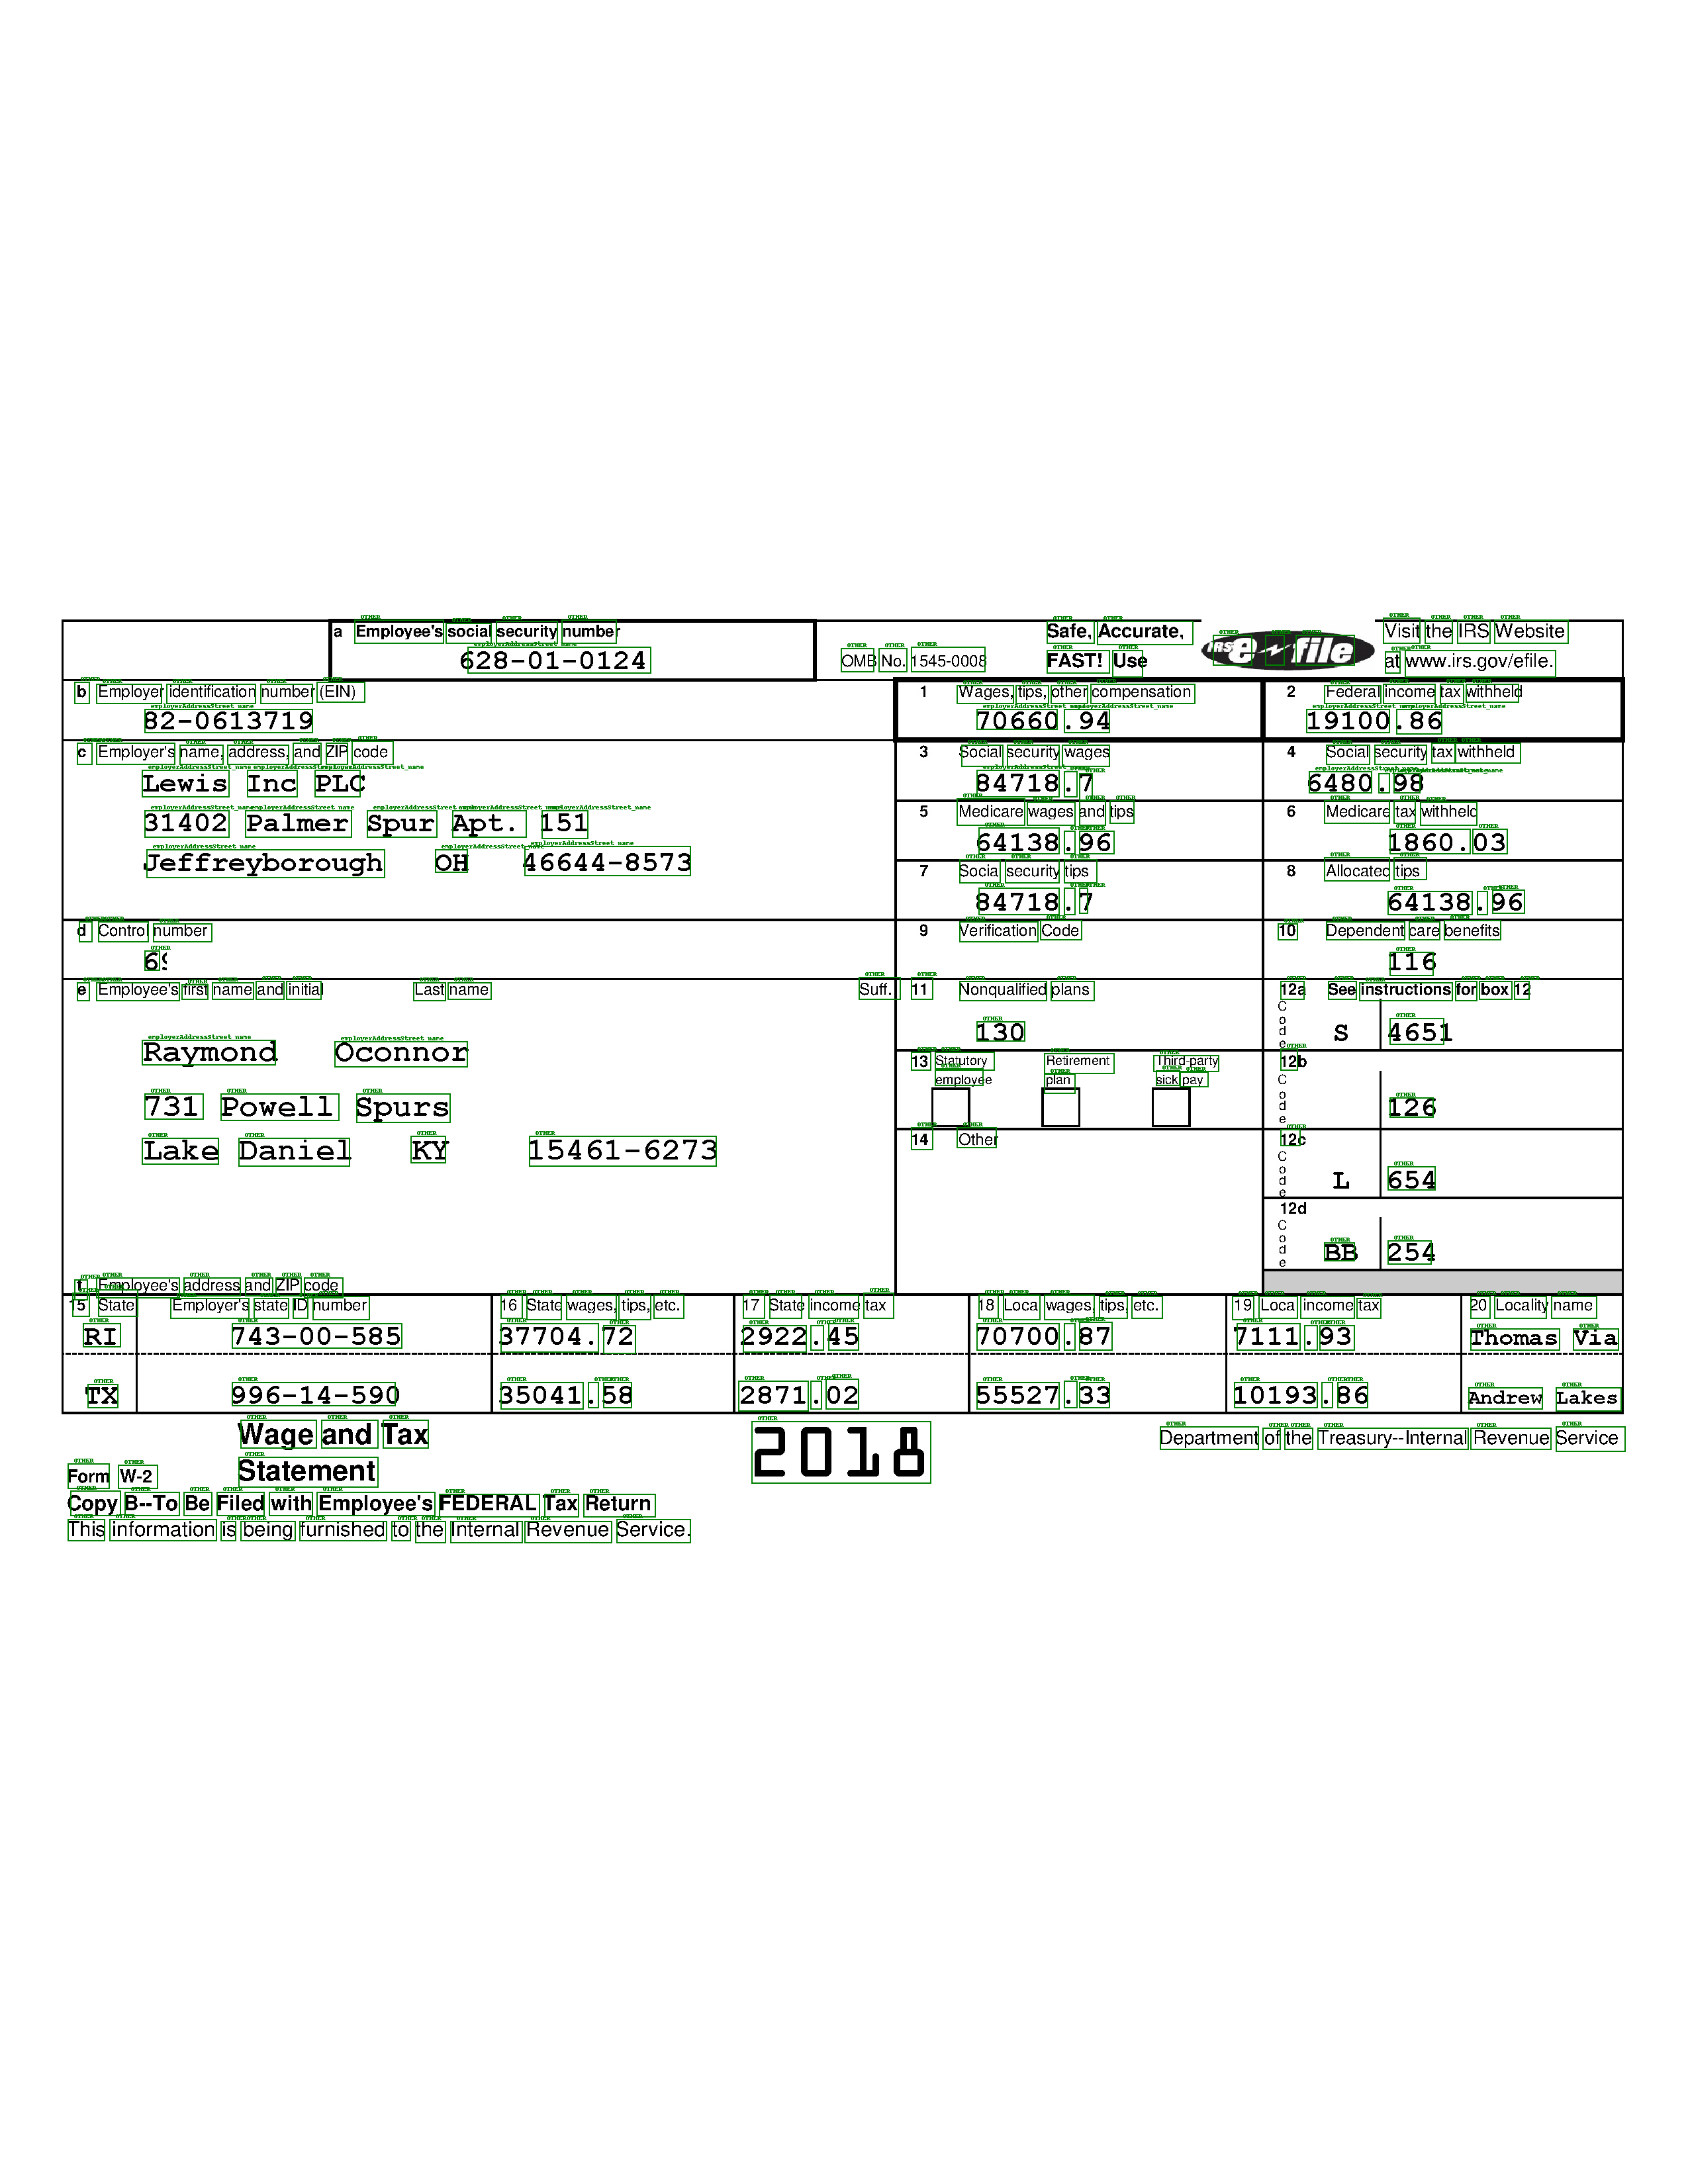

In [80]:
from PIL import ImageDraw, ImageFont
height,width=image.size
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()


label2color = {'box1WagesTipsAndOtherCompensations':'blue', 'box2FederalIncomeTaxWithheld':'green', 'box3SocialSecurityWages':'orange', 'box4SocialSecurityTaxWithheld':'violet','employerName': 'blue', 'employerAddressStreet_name': 'green', 'employerAddressCity': 'orange', 'employerAddressState': 'violet','employerAddressZip': 'violet', 'einEmployerIdentificationNumber': 'orange', 'ssnOfEmployee': 'green','employeeName': 'blue', 'box16StateWagesTips': 'blue', 'box17StateIncomeTax': 'green', 'OTHER': 'green', 'taxYear': 'green'}

true_predictions
for prediction, box in zip(true_predictions, boxes): # true_boxes
    predicted_label = iob_to_label(prediction)#.lower()
    un_box=unnormalize_box(box, width, height)
    box_2=[]
    for i in un_box:
      box_2.append(round(i))

#    print(box_2)
#   print(predicted_label)
    draw.rectangle(box_2,outline=label2color[predicted_label],width=2)
    draw.text((box_2[0] + 10, box_2[1] - 10) , text=predicted_label, fill=label2color[predicted_label], font=font)

image

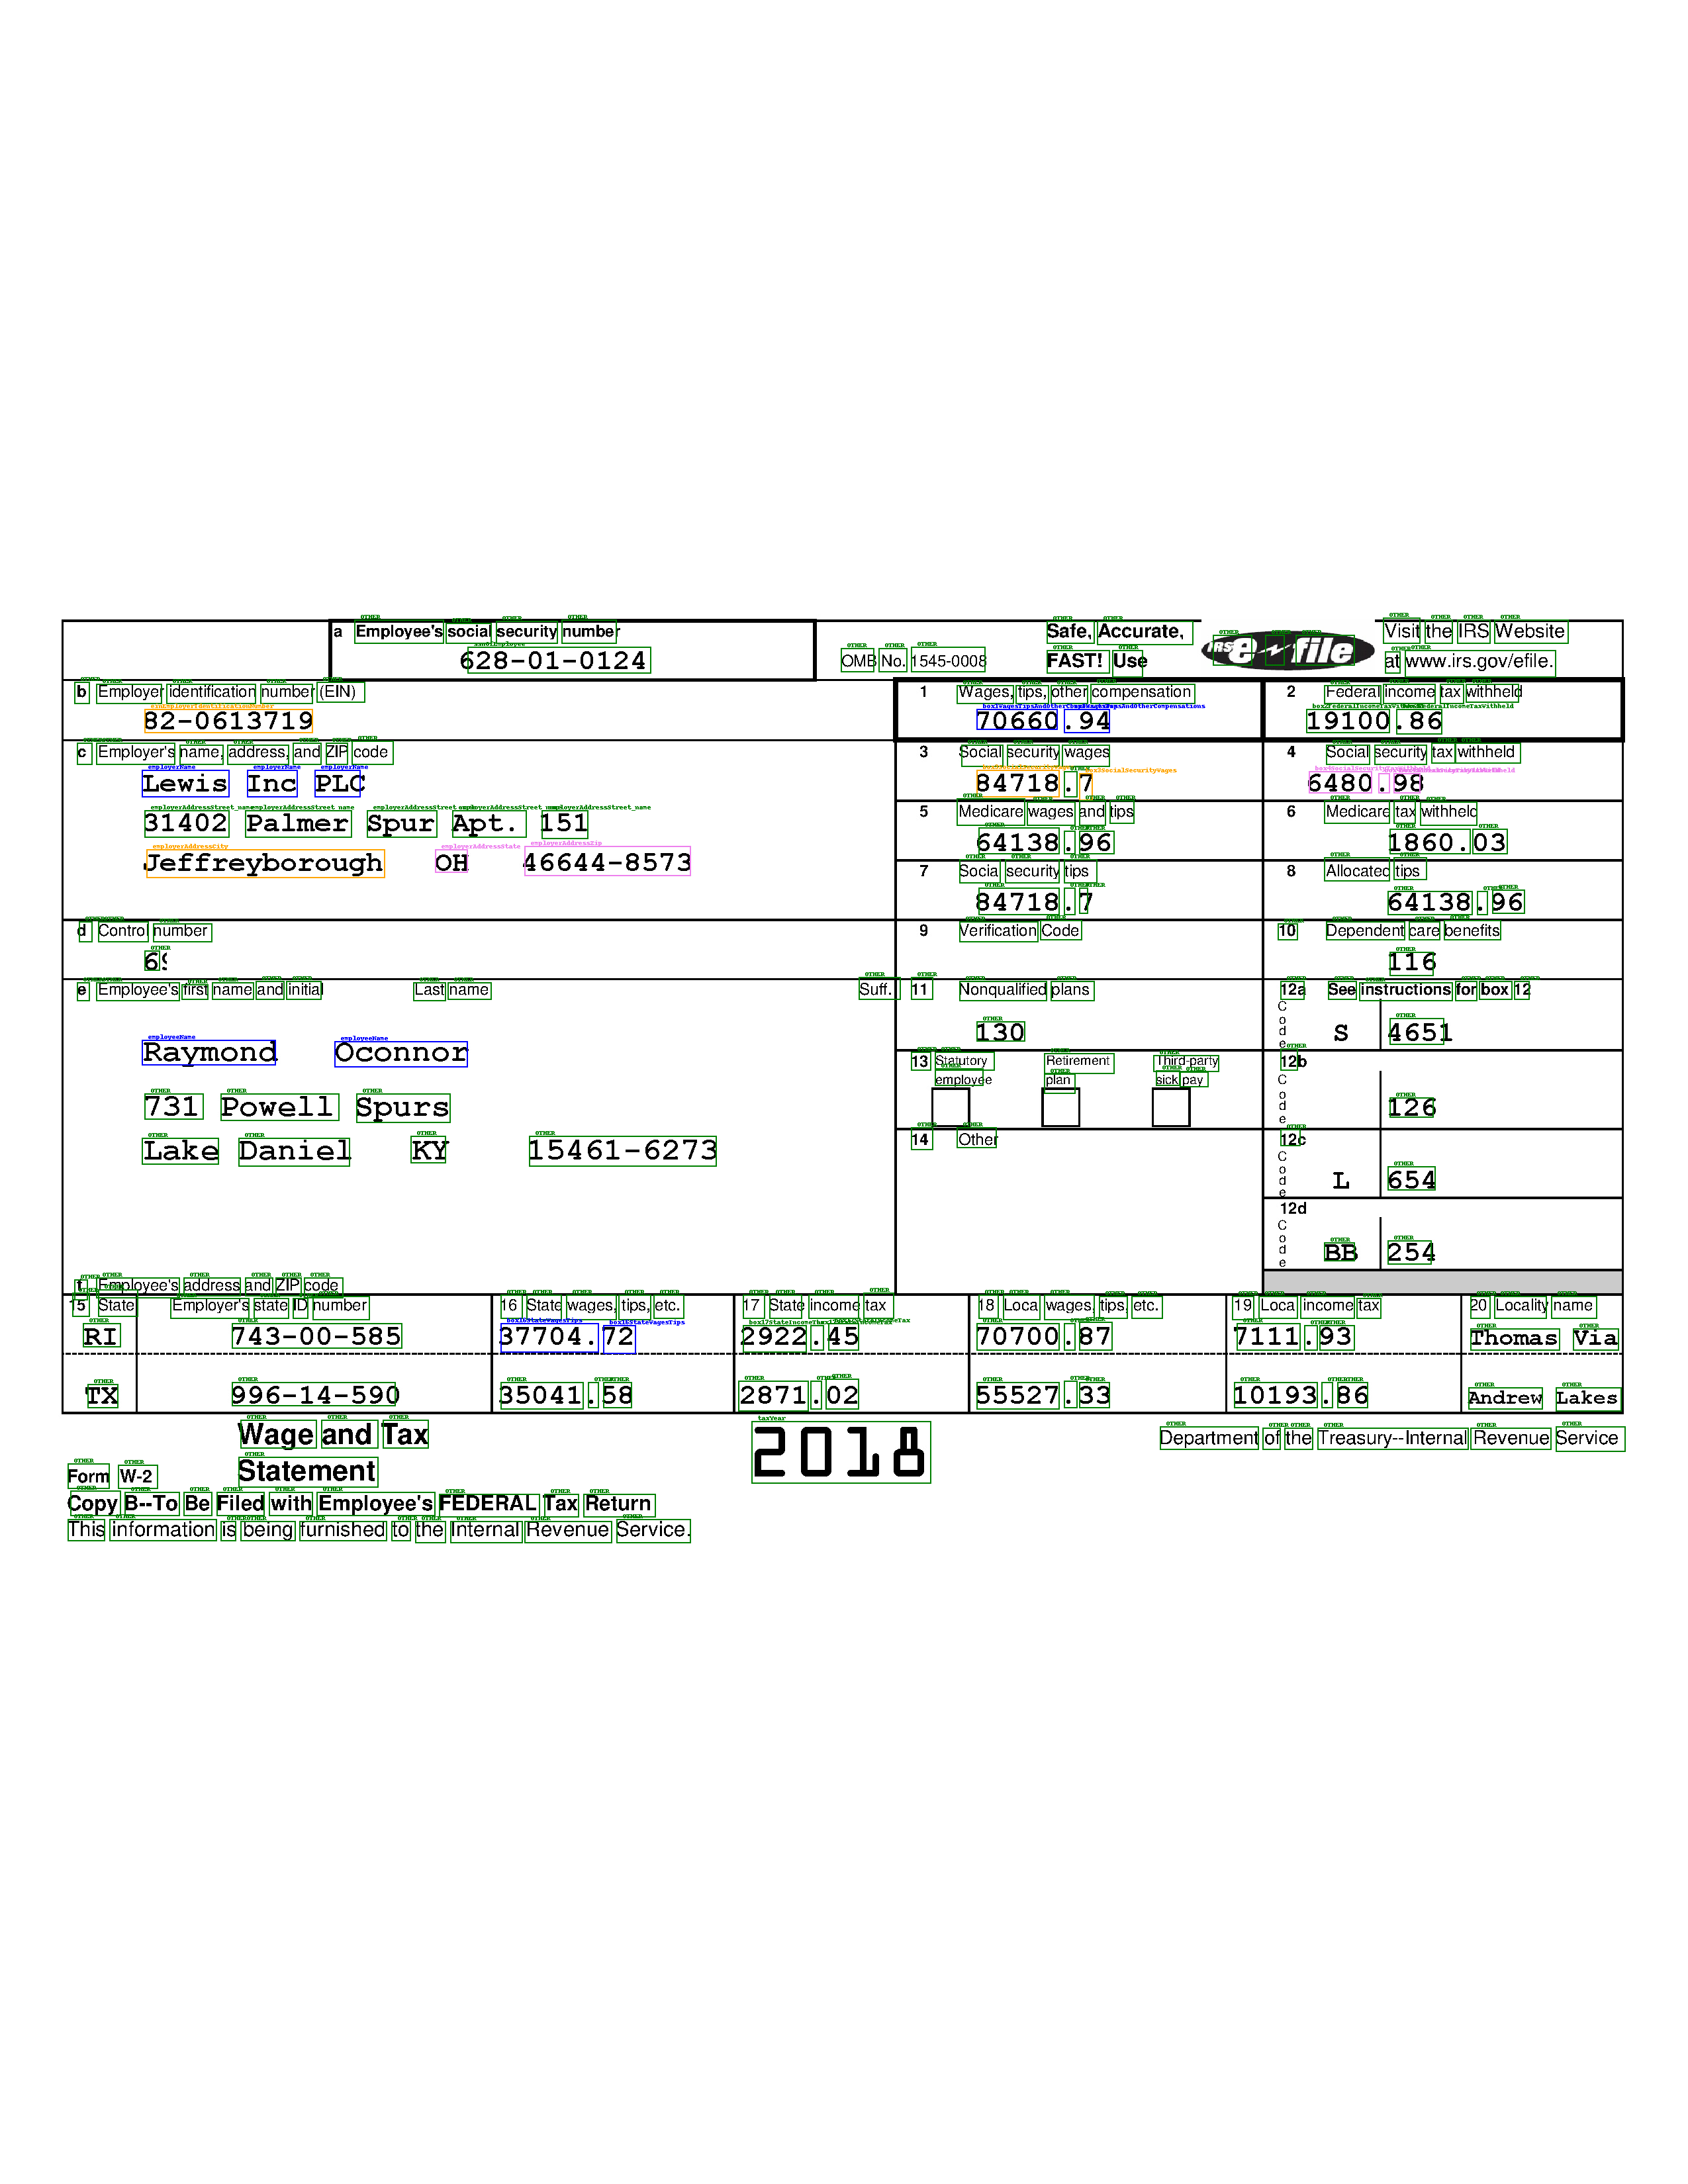

In [81]:
example=eval_dataset_dict[0]
example.keys()

image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
word_labels = example["ner_tags"]
id2label
second=[]
for i in range(len(word_labels)):
  val=word_labels[i]
  second.append(id2label[val])
#print(id2label[i])

from PIL import ImageDraw, ImageFont
height,width=image.size
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()


label2color = {'box1WagesTipsAndOtherCompensations':'blue', 'box2FederalIncomeTaxWithheld':'green', 'box3SocialSecurityWages':'orange', 'box4SocialSecurityTaxWithheld':'violet','employerName': 'blue', 'employerAddressStreet_name': 'green', 'employerAddressCity': 'orange', 'employerAddressState': 'violet','employerAddressZip': 'violet', 'einEmployerIdentificationNumber': 'orange', 'ssnOfEmployee': 'green','employeeName': 'blue', 'box16StateWagesTips': 'blue', 'box17StateIncomeTax': 'green', 'OTHER': 'green', 'taxYear': 'green'}

true_predictions=second
for prediction, box in zip(true_predictions, boxes): # true_boxes
    predicted_label = iob_to_label(prediction)#.lower()
    un_box=unnormalize_box(box, width, height)
    box_2=[]
    for i in un_box:
      box_2.append(round(i))

#    print(box_2)
#   print(predicted_label)
    draw.rectangle(box_2,outline=label2color[predicted_label],width=2)
    draw.text((box_2[0] + 10, box_2[1] - 10) , text=predicted_label, fill=label2color[predicted_label], font=font)

image

In [88]:
actual_label=word_labels
for act,pred in zip(actual_label,predictions):
  print(f'actual_label:{act} >> predicted_label:{pred}')

actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:10 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:14
actual_label:14 >> predicted_label:5
actual_label:14 >> predicted_label:5
actual_label:14 >> predicted_label:5
actual_label:14 >> predicted_label:5
actual_label:14 >> predicted_label:5
actual_label:14 >> predicted_label:5
actual_label:14 >> predicted_label:5
actual_label:14 >> 